# Yu-Ting Shen

# RiskGenius Challenge Project


https://www.irmi.com/glossary

https://scrapy.org/

The IRMI link points to a site with definitions of insurance terms.
The Scrapy link is to a library which can extract data from websites.

The idea of this project is in 3 parts:

1. Scrape and store the IRMI glossary into some data format (maybe SQLite, or .json or something).  Be sure to have at least the definition label and definition text.  Other data might be unnecessary.

2. Build a classifier (you can choose the model) and optimize hyperparameters to predict the definition label from the definition text.

3. Predict the word that will be in the definition label, instead of the label itself.  Possibly predict the count vector of the definition label in this case.

This could have a real application in RiskGenius, as a step toward automatically generating definition labels by predicting the words that would be used in definition labels.  You are likely to find in many cases, words in the definition label cannot be found in the definition text, so keep that in mind.

***
***
***

# Load Data

In [93]:
import pandas as pd

df_insurance_terms = pd.read_csv('terms.csv')
df_insurance_terms.head()

,term,text,synonym
0,automatic premium loan,An optional provision in life insurance that a...,NaN
1,Household Goods Transportation Act of 1980,Provided a nonjudicial dispute settlement prog...,NaN
2,hydrocarbons,A class of organic compounds composed only of ...,NaN
3,hydraulic fracturing (fracking),A process in which fractures in hard-to-reach ...,NaN
4,hybrid plans,Risk financing techniques that are a combinati...,NaN


In [94]:
df_insurance_terms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3261 entries, 0 to 3260
Data columns (total 3 columns):
term       3261 non-null object
text       3261 non-null object
synonym    18 non-null object
dtypes: object(3)
memory usage: 76.5+ KB


In [95]:
# Only keep term and text
df = df_insurance_terms[['term', 'text']]
df.head()

,term,text
0,automatic premium loan,An optional provision in life insurance that a...
1,Household Goods Transportation Act of 1980,Provided a nonjudicial dispute settlement prog...
2,hydrocarbons,A class of organic compounds composed only of ...
3,hydraulic fracturing (fracking),A process in which fractures in hard-to-reach ...
4,hybrid plans,Risk financing techniques that are a combinati...


# Try KMeans clustering on term and text

In [96]:
df_kmeans = df.copy()

# documents = df_kmeans['text'].str.lower()
# labels = df_kmeans['term'].str.lower()
# print(len(documents), len(labels), documents.shape, labels.shape)

from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()

def normalize_string(string):
    '''
    normalize original string:
    1. remove punctuation
    2. use lower case
    3. lemmatize
    '''
    # Remove punctuation
    string = re.sub('[<(!?).,*->]', ' ', string)
    # Convert to lower case
    string = string.lower()
    # Lemmatization
    string = [stemmer.lemmatize(word) for word in string.split()]
    # joint list
    return ' '.join(string)
    
df_kmeans['norm_term'] = df_kmeans['term'].apply(lambda x: normalize_string(x))
df_kmeans['norm_text'] = df_kmeans['text'].apply(lambda x: normalize_string(x))

df_kmeans.head()

,term,text,norm_term,norm_text
0,automatic premium loan,An optional provision in life insurance that a...,automatic premium loan,an optional provision in life insurance that a...
1,Household Goods Transportation Act of 1980,Provided a nonjudicial dispute settlement prog...,household good transportation act of,provided a nonjudicial dispute settlement prog...
2,hydrocarbons,A class of organic compounds composed only of ...,hydrocarbon,a class of organic compound composed only of c...
3,hydraulic fracturing (fracking),A process in which fractures in hard-to-reach ...,hydraulic fracturing fracking,a process in which fracture in hard to reach s...
4,hybrid plans,Risk financing techniques that are a combinati...,hybrid plan,risk financing technique that are a combinatio...


In [97]:
documents = df_kmeans['norm_text'].str.lower()
labels = df_kmeans['norm_term'].str.lower()
print(len(documents), len(labels), documents.shape, labels.shape)

3261 3261 (3261,) (3261,)


I want to do the document classification.
* Use text (document) to predict term (label)

There are 3261 labels (categories). I cannot use `train_test_split()` to split training and test samples because each documents belong different categories. Instead, I can cluster the labels into several groups. And use the text to predict which group it should be.

* Try `KMeans()` with n clusters

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer

label_vectorizer = TfidfVectorizer(stop_words='english')
label_vect = label_vectorizer.fit_transform(labels).toarray()
label_words = label_vectorizer.get_feature_names()

text_vectorizer = TfidfVectorizer(stop_words='english')
text_vect = text_vectorizer.fit_transform(documents).toarray()
text_words = text_vectorizer.get_feature_names()

In [99]:
print(len(label_words), len(text_words))

2677 7261


* Cluster 'term' using default 8 clusters
  * kmeans1

In [100]:
from sklearn.cluster import KMeans
kmeans1 = KMeans().fit(label_vect) # n_cluster=8 by default

In [101]:
print(kmeans1.labels_.size)
kmeans1.labels_

3261


array([7, 3, 7, ..., 7, 7, 7], dtype=int32)

In [102]:
import numpy as np
np.unique(kmeans1.labels_) # check number of clusters

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [103]:
kmeans1.cluster_centers_ # cluster center

array([[ 2.43866934e-03,  2.55141165e-03,  0.00000000e+00, ...,
         4.60785923e-19, -2.71050543e-20, -2.05998413e-18],
       [-2.71050543e-19, -8.40256684e-19,  0.00000000e+00, ...,
         3.52365706e-19, -4.87890978e-19, -1.30104261e-18],
       [-3.52365706e-19, -7.04731412e-19,  0.00000000e+00, ...,
         2.71050543e-19, -7.04731412e-19, -6.50521303e-19],
       ...,
       [-2.98155597e-19, -1.89735380e-19,  0.00000000e+00, ...,
        -1.08420217e-19, -2.43945489e-19,  1.19262239e-18],
       [-2.98155597e-19, -2.71050543e-19,  0.00000000e+00, ...,
        -5.42101086e-20, -2.98155597e-19,  1.19262239e-18],
       [-7.31836466e-18,  5.50232603e-18,  2.56683045e-04, ...,
         2.73898020e-04,  2.70554914e-04,  7.92289658e-04]])

In [104]:
print(kmeans1.labels_.shape)
print(kmeans1.cluster_centers_.shape)

(3261,)
(8, 2677)


* Cluster 'text' using 8 default clusters
  * kmeans2

In [106]:
kmeans2 = KMeans().fit(text_vect) # n_cluster=8 by default

print(kmeans2.labels_.size)
print(kmeans2.labels_)
print(np.unique(kmeans2.labels_))
print(kmeans2.cluster_centers_)
print(kmeans2.labels_.shape)
print(kmeans2.cluster_centers_.shape)

3261
[0 5 5 ... 5 5 2]
[0 1 2 3 4 5 6 7]
[[ 6.05096521e-04  1.69406589e-19  8.35198178e-04 ...  7.31836466e-19
  -2.87313576e-18 -5.55653613e-19]
 [ 1.24683250e-18  0.00000000e+00  2.27682456e-18 ...  4.33680869e-19
  -2.54787511e-18 -5.28548559e-19]
 [ 1.41640216e-03  3.74486007e-04  1.13009511e-03 ...  1.19262239e-18
   1.52184030e-04 -5.96311195e-19]
 ...
 [-7.91467586e-18  9.96110746e-19  3.57313107e-04 ...  3.18543371e-04
   9.84362302e-04  2.32063544e-04]
 [ 1.08420217e-18  2.03287907e-20  1.02999206e-18 ... -4.87890978e-19
  -1.13841228e-18 -4.20128342e-19]
 [-1.08420217e-19 -6.77626358e-21 -3.25260652e-19 ...  5.42101086e-20
   1.62630326e-19  2.71050543e-20]]
(3261,)
(8, 7261)


* Use different number of clusters
  * Optimize k value using elbow method

In [107]:
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
def optimize_k(vectors):
    distortions = []
    for n in range(1, 3001, 500):
        kmeans = KMeans(n_clusters=n).fit(vectors)
        distortions.append(sum(np.min(cdist(vectors, kmeans.cluster_centers_, 'euclidean'), axis=1)) / vectors.shape[0])
    return distortions

# Plot the elbow
def elbow_plot(distortions):
    plt.plot(range(1, 3001, 500), distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

* For term

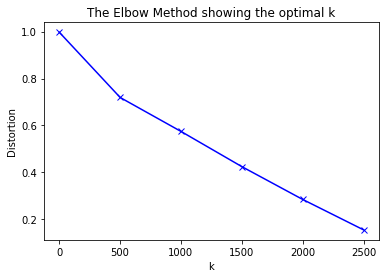

In [109]:
dist_label = optimize_k(label_vect)
elbow_plot(dist_label)

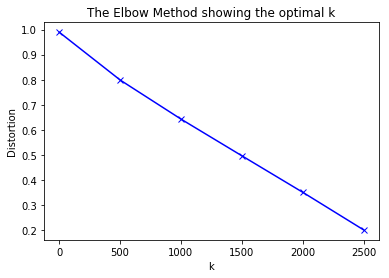

In [110]:
dist_label = optimize_k(text_vect)
elbow_plot(dist_label)

* No obvious turning point of K
  * For term, there is slightly changes in the slop around k = 500.
  * For text, the the line almost straight.
  
* **Conclusion**: The clustering doesn't work for this case.

# Try to divide 26 groups using the first character

* Because a-z has 26 characters, can I divide the term based on the first character?

* Normalize term and text
  * Lower case
  * Remove punctuations
  
* Use first character to divide into different groups.

In [113]:
df_26 = df.copy()
df_26['lower_term'] = df_26['term'].str.lower()
df_26['lower_text'] = df_26['text'].str.lower()

import re

df_26['lower_term'] = df_26['lower_term'].apply(lambda x: ' '.join([i for i in re.sub('[<(!?).,*->]', ' ', x).split()]))
df_26['lower_text'] = df_26['lower_text'].apply(lambda x: ' '.join([i for i in re.sub('[<(!?).,*->]', ' ', x).split()]))

df_26['first_char'] = df_26['lower_term'].str[0]

df_26.head()

,term,text,lower_term,lower_text,first_char
0,automatic premium loan,An optional provision in life insurance that a...,automatic premium loan,an optional provision in life insurance that a...,a
1,Household Goods Transportation Act of 1980,Provided a nonjudicial dispute settlement prog...,household goods transportation act of,provided a nonjudicial dispute settlement prog...,h
2,hydrocarbons,A class of organic compounds composed only of ...,hydrocarbons,a class of organic compounds composed only of ...,h
3,hydraulic fracturing (fracking),A process in which fractures in hard-to-reach ...,hydraulic fracturing fracking,a process in which fractures in hard to reach ...,h
4,hybrid plans,Risk financing techniques that are a combinati...,hybrid plans,risk financing techniques that are a combinati...,h


In [114]:
df_26['first_char'].value_counts()

c    394
p    295
s    251
a    240
r    223
e    210
f    187
d    177
m    160
i    157
b    148
l    140
t    112
n    111
o     89
g     79
w     76
u     59
h     57
v     45
j     21
q     13
k     10
z      4
y      3
Name: first_char, dtype: int64

In [119]:
percentage = df_26['first_char'].value_counts() / df_26['first_char'].value_counts().sum() * 100
print(percentage)

c    12.082183
p     9.046305
s     7.697025
a     7.359706
r     6.838393
e     6.439742
f     5.734437
d     5.427783
m     4.906470
i     4.814474
b     4.538485
l     4.293162
t     3.434529
n     3.403864
o     2.729224
g     2.422570
w     2.330573
u     1.809261
h     1.747930
v     1.379945
j     0.643974
q     0.398651
k     0.306654
z     0.122662
y     0.091996
Name: first_char, dtype: float64


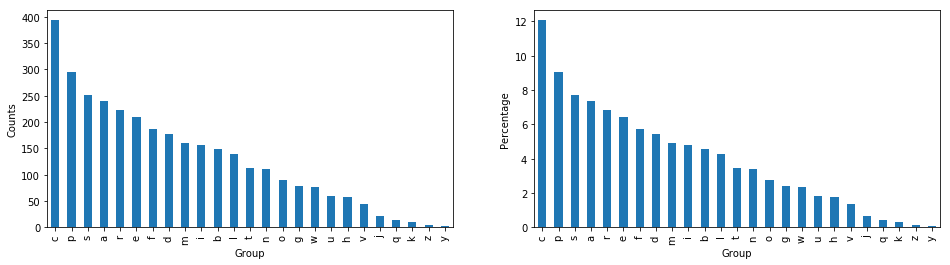

In [129]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_26['first_char'].value_counts().plot.bar(ax=ax1)
ax1.set_xlabel('Group')
ax1.set_ylabel('Counts')

percentage.plot(kind='bar', ax=ax2)
ax2.set_xlabel('Group')
ax2.set_ylabel('Percentage')

plt.show()

* Use Naive Bayes to categorize group

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(df_26['lower_term'].values, df_26['first_char'].values, test_size=0.3, random_state=42)

pipe = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', ngram_range=(1, 5), stop_words='english')),
                 ('clf', MultinomialNB())
                ])

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 5), norm='l2', preprocessor=None, smooth_idf=True,...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [131]:
preds = pipe.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           a       0.55      0.28      0.38        74
           b       0.20      0.03      0.05        38
           c       0.18      0.85      0.30       128
           d       0.54      0.13      0.21        53
           e       0.53      0.39      0.45        59
           f       0.77      0.30      0.43        57
           g       1.00      0.15      0.27        13
           h       0.00      0.00      0.00        16
           i       1.00      0.07      0.12        45
           j       0.00      0.00      0.00         2
           k       0.00      0.00      0.00         5
           l       0.57      0.09      0.15        47
           m       0.86      0.11      0.20        53
           n       0.00      0.00      0.00        32
           o       0.00      0.00      0.00        30
           p       0.31      0.44      0.37        95
           q       0.00      0.00      0.00         5
           r       0.28    

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


* From the classification report, I get very low precision using NB.
  * Also try linearSVC and RandomForest but still get low precision.

In [138]:
from sklearn.svm import LinearSVC
pipe_svm = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', ngram_range=(1, 5), stop_words='english')),
                 ('clf', LinearSVC(loss='hinge', C=0.1))
                ])

pipe_svm.fit(X_train, y_train)

preds_svm = pipe.predict(X_test)

print(classification_report(y_test, preds_svm))

              precision    recall  f1-score   support

           a       0.55      0.28      0.38        74
           b       0.20      0.03      0.05        38
           c       0.18      0.85      0.30       128
           d       0.54      0.13      0.21        53
           e       0.53      0.39      0.45        59
           f       0.77      0.30      0.43        57
           g       1.00      0.15      0.27        13
           h       0.00      0.00      0.00        16
           i       1.00      0.07      0.12        45
           j       0.00      0.00      0.00         2
           k       0.00      0.00      0.00         5
           l       0.57      0.09      0.15        47
           m       0.86      0.11      0.20        53
           n       0.00      0.00      0.00        32
           o       0.00      0.00      0.00        30
           p       0.31      0.44      0.37        95
           q       0.00      0.00      0.00         5
           r       0.28    

In [139]:
from  sklearn.ensemble import RandomForestClassifier
pipe_rf = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', ngram_range=(1, 5), stop_words='english')),
                 ('clf', RandomForestClassifier())
                ])

pipe_rf.fit(X_train, y_train)

preds_rf = pipe.predict(X_test)

print(classification_report(y_test, preds_rf))

              precision    recall  f1-score   support

           a       0.55      0.28      0.38        74
           b       0.20      0.03      0.05        38
           c       0.18      0.85      0.30       128
           d       0.54      0.13      0.21        53
           e       0.53      0.39      0.45        59
           f       0.77      0.30      0.43        57
           g       1.00      0.15      0.27        13
           h       0.00      0.00      0.00        16
           i       1.00      0.07      0.12        45
           j       0.00      0.00      0.00         2
           k       0.00      0.00      0.00         5
           l       0.57      0.09      0.15        47
           m       0.86      0.11      0.20        53
           n       0.00      0.00      0.00        32
           o       0.00      0.00      0.00        30
           p       0.31      0.44      0.37        95
           q       0.00      0.00      0.00         5
           r       0.28    

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


* Try to add lemmatization or stemming

In [133]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def lemma(string):
    tokens = word_tokenize(string)
    words = []
    for token in tokens:
        words.append(lemmatizer.lemmatize(token))
    return ' '.join(words)

s = df_26['lower_term']
s.apply(lambda x: lemma(x))

0                             automatic premium loan
1               household good transportation act of
2                                        hydrocarbon
3                      hydraulic fracturing fracking
4                                        hybrid plan
5                                     hybrid captive
6                                        hurdle rate
7                                             hybrid
8                            job safety analysis jsa
9                         improvement and betterment
10                                  implied warranty
11                                 implied authority
12                                           implead
13                                impairment capital
14                            incorporation doctrine
15                              incontestable clause
16                      incident reporting provision
17                       management advisory service
18                     managed care organizati

In [134]:
df_26['lower_term'].str.split()

0                              [automatic, premium, loan]
1             [household, goods, transportation, act, of]
2                                          [hydrocarbons]
3                       [hydraulic, fracturing, fracking]
4                                         [hybrid, plans]
5                                       [hybrid, captive]
6                                          [hurdle, rate]
7                                                [hybrid]
8                            [job, safety, analysis, jsa]
9                        [improvements, and, betterments]
10                                    [implied, warranty]
11                                   [implied, authority]
12                                              [implead]
13                                  [impairment, capital]
14                              [incorporation, doctrine]
15                                [incontestable, clause]
16                       [incident, reporting, provision]
17            

* Check term frequency in `df['lower_term']` column

In [135]:
from nltk.probability import FreqDist
FreqDist(df_26['lower_term'])

FreqDist({'fas': 3, 'class insureds': 2, 'terrorism risk insurance program reauthorization act of tripra': 2, 'automatic premium loan': 1, 'household goods transportation act of': 1, 'hydrocarbons': 1, 'hydraulic fracturing fracking': 1, 'hybrid plans': 1, 'hybrid captive': 1, 'hurdle rate': 1, ...})

In [136]:
df_26['tokenized_term'] = df_26.apply(lambda row: word_tokenize(row['lower_term']), axis=1)
df_26.head()

,term,text,lower_term,lower_text,first_char,tokenized_term
0,automatic premium loan,An optional provision in life insurance that a...,automatic premium loan,an optional provision in life insurance that a...,a,"[automatic, premium, loan]"
1,Household Goods Transportation Act of 1980,Provided a nonjudicial dispute settlement prog...,household goods transportation act of,provided a nonjudicial dispute settlement prog...,h,"[household, goods, transportation, act, of]"
2,hydrocarbons,A class of organic compounds composed only of ...,hydrocarbons,a class of organic compounds composed only of ...,h,[hydrocarbons]
3,hydraulic fracturing (fracking),A process in which fractures in hard-to-reach ...,hydraulic fracturing fracking,a process in which fractures in hard to reach ...,h,"[hydraulic, fracturing, fracking]"
4,hybrid plans,Risk financing techniques that are a combinati...,hybrid plans,risk financing techniques that are a combinati...,h,"[hybrid, plans]"


In [140]:
# Still working on it...